## Подключение библиотек и определение класса Dataset

In [85]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window, output):
        self.data = data
        self.window = window
        self.output = output

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        y = self.data[index+self.window:index+self.window+self.output]
        return x, y

    def __len__(self):
        return len(self.data) - self.window - self.output

## Определение параметров модели

In [86]:
input_size = 15
pred = input_size
learning_rate = 0.0001
output_size = 100
data_size  = 5000
step = 10
m = 10 #на сколько шагов предсказать
data_set = 10000
column_name = "HUFL"
model_name = f"update_model_v6_L1_SGD_{column_name}_input{input_size}_output{output_size}"


## Класс деокмпозиции временного ряда для получение сезонной и трендовой составляющей

In [87]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

## Класс DLinear и функция для обучения модели

In [88]:
class DLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, output_size)
        self.linear_trend = nn.Linear(input_size, output_size)
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X, Y in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()


In [89]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data[column_name].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [90]:
model = DLinearModel(input_size, output_size)
criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#TODO: переписать dataloader для правильно обучения

window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size, output_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [91]:
len(dataloader)

385

In [92]:
train_model(model, dataloader, criterion, optimizer)


Epoch =  0


c:\Users\evgen\miniconda3\envs\MyDLinear\Lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1, 100, 1])) that is different to the input size (torch.Size([1, 1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch =  1
Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Epoch =  40
Epoch =  41
Epoch =  42
Epoch =  43
Epoch =  44
Epoch =  45
Epoch =  46
Epoch =  47
Epoch =  48
Epoch =  49
Epoch =  50
Epoch =  51
Epoch =  52
Epoch =  53
Epoch =  54
Epoch =  55
Epoch =  56
Epoch =  57
Epoch =  58
Epoch =  59
Epoch =  60
Epoch =  61
Epoch =  62
Epoch =  63
Epoch =  64
Epoch =  65
Epoch =  66
Epoch =  67
Epoch =  68
Epoch =  69
Epoch =  70
Epoch =  71
Epoch =  72
Epoch =  73
Epoch =  74
Epoch =  75
Epoch =  76
Epoch =  77
Epoch =  78
Epoch =  79
Epoch =  80
Epoch =  81
Epoch =  82
Epoch =  83
Epoch =  84
E

In [93]:
torch.save(model.state_dict(), model_name)

In [94]:
model.load_state_dict(torch.load(model_name))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=15, out_features=100, bias=True)
  (linear_trend): Linear(in_features=15, out_features=100, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(15,), stride=(1,), padding=(0,))
  )
)

In [95]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=15, out_features=100, bias=True)
  (linear_trend): Linear(in_features=15, out_features=100, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(15,), stride=(1,), padding=(0,))
  )
)>

In [96]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [97]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data[column_name].values[data_set-pred:data_set-pred+pred*step:step], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred, output_size)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[14.9370],
        [-8.7740],
        [13.0610],
        [ 9.1760],
        [ 5.6260],
        [14.2000],
        [-7.5020],
        [17.8170],
        [ 0.6030],
        [13.4630],
        [15.4050],
        [-4.2870],
        [11.6550],
        [ 4.5550],
        [ 9.7120]])
tensor([[14.9370],
        [-8.7740],
        [13.0610],
        [ 9.1760],
        [ 5.6260],
        [14.2000],
        [-7.5020],
        [17.8170],
        [ 0.6030],
        [13.4630],
        [15.4050],
        [-4.2870],
        [11.6550],
        [ 4.5550],
        [ 9.7120]])


tensor([[14.9370],
        [-8.7740],
        [13.0610],
        [ 9.1760],
        [ 5.6260],
        [14.2000],
        [-7.5020],
        [17.8170],
        [ 0.6030],
        [13.4630],
        [15.4050],
        [-4.2870],
        [11.6550],
        [ 4.5550],
        [ 9.7120]])

In [98]:
X_t = X_f.tolist()
X_t

[[14.937000274658203],
 [-8.77400016784668],
 [13.060999870300293],
 [9.175999641418457],
 [5.625999927520752],
 [14.199999809265137],
 [-7.501999855041504],
 [17.816999435424805],
 [0.6029999852180481],
 [13.463000297546387],
 [15.404999732971191],
 [-4.2870001792907715],
 [11.654999732971191],
 [4.554999828338623],
 [9.711999893188477]]

In [99]:

predicted_values = []




    
X = torch.tensor([X_t])
prediction = model(X)
predicted_values = prediction.tolist()[-1][-1]

      
    


future_predictions = predicted_values

In [100]:
predicted_values

[8.995926856994629,
 13.548168182373047,
 2.4518051147460938,
 7.749964714050293,
 12.3829345703125,
 16.179105758666992,
 12.231012344360352,
 9.099310874938965,
 1.619297981262207,
 2.8070406913757324,
 5.868373870849609,
 12.528643608093262,
 7.726776123046875,
 8.534565925598145,
 5.613466739654541,
 3.9044060707092285,
 8.198725700378418,
 0.727104663848877,
 11.650075912475586,
 9.493969917297363,
 12.174206733703613,
 12.89617919921875,
 7.298454284667969,
 7.972562313079834,
 9.708464622497559,
 5.237814903259277,
 6.813442707061768,
 8.37379264831543,
 1.1684041023254395,
 10.683801651000977,
 7.083446502685547,
 11.044649124145508,
 -2.2574658393859863,
 11.069730758666992,
 9.769222259521484,
 15.244392395019531,
 4.579593658447266,
 4.418820858001709,
 6.901044845581055,
 8.390183448791504,
 13.581496238708496,
 3.8578577041625977,
 8.86385440826416,
 6.583978652954102,
 3.2449755668640137,
 5.262386322021484,
 3.1509714126586914,
 7.963558197021484,
 9.370339393615723,
 11

In [101]:
future_predictions

[8.995926856994629,
 13.548168182373047,
 2.4518051147460938,
 7.749964714050293,
 12.3829345703125,
 16.179105758666992,
 12.231012344360352,
 9.099310874938965,
 1.619297981262207,
 2.8070406913757324,
 5.868373870849609,
 12.528643608093262,
 7.726776123046875,
 8.534565925598145,
 5.613466739654541,
 3.9044060707092285,
 8.198725700378418,
 0.727104663848877,
 11.650075912475586,
 9.493969917297363,
 12.174206733703613,
 12.89617919921875,
 7.298454284667969,
 7.972562313079834,
 9.708464622497559,
 5.237814903259277,
 6.813442707061768,
 8.37379264831543,
 1.1684041023254395,
 10.683801651000977,
 7.083446502685547,
 11.044649124145508,
 -2.2574658393859863,
 11.069730758666992,
 9.769222259521484,
 15.244392395019531,
 4.579593658447266,
 4.418820858001709,
 6.901044845581055,
 8.390183448791504,
 13.581496238708496,
 3.8578577041625977,
 8.86385440826416,
 6.583978652954102,
 3.2449755668640137,
 5.262386322021484,
 3.1509714126586914,
 7.963558197021484,
 9.370339393615723,
 11

In [102]:
len(future_predictions)

100

Future Predictions: [8.995926856994629, 13.548168182373047, 2.4518051147460938, 7.749964714050293, 12.3829345703125, 16.179105758666992, 12.231012344360352, 9.099310874938965, 1.619297981262207, 2.8070406913757324, 5.868373870849609, 12.528643608093262, 7.726776123046875, 8.534565925598145, 5.613466739654541, 3.9044060707092285, 8.198725700378418, 0.727104663848877, 11.650075912475586, 9.493969917297363, 12.174206733703613, 12.89617919921875, 7.298454284667969, 7.972562313079834, 9.708464622497559, 5.237814903259277, 6.813442707061768, 8.37379264831543, 1.1684041023254395, 10.683801651000977, 7.083446502685547, 11.044649124145508, -2.2574658393859863, 11.069730758666992, 9.769222259521484, 15.244392395019531, 4.579593658447266, 4.418820858001709, 6.901044845581055, 8.390183448791504, 13.581496238708496, 3.8578577041625977, 8.86385440826416, 6.583978652954102, 3.2449755668640137, 5.262386322021484, 3.1509714126586914, 7.963558197021484, 9.370339393615723, 11.633816719055176, 6.635112762

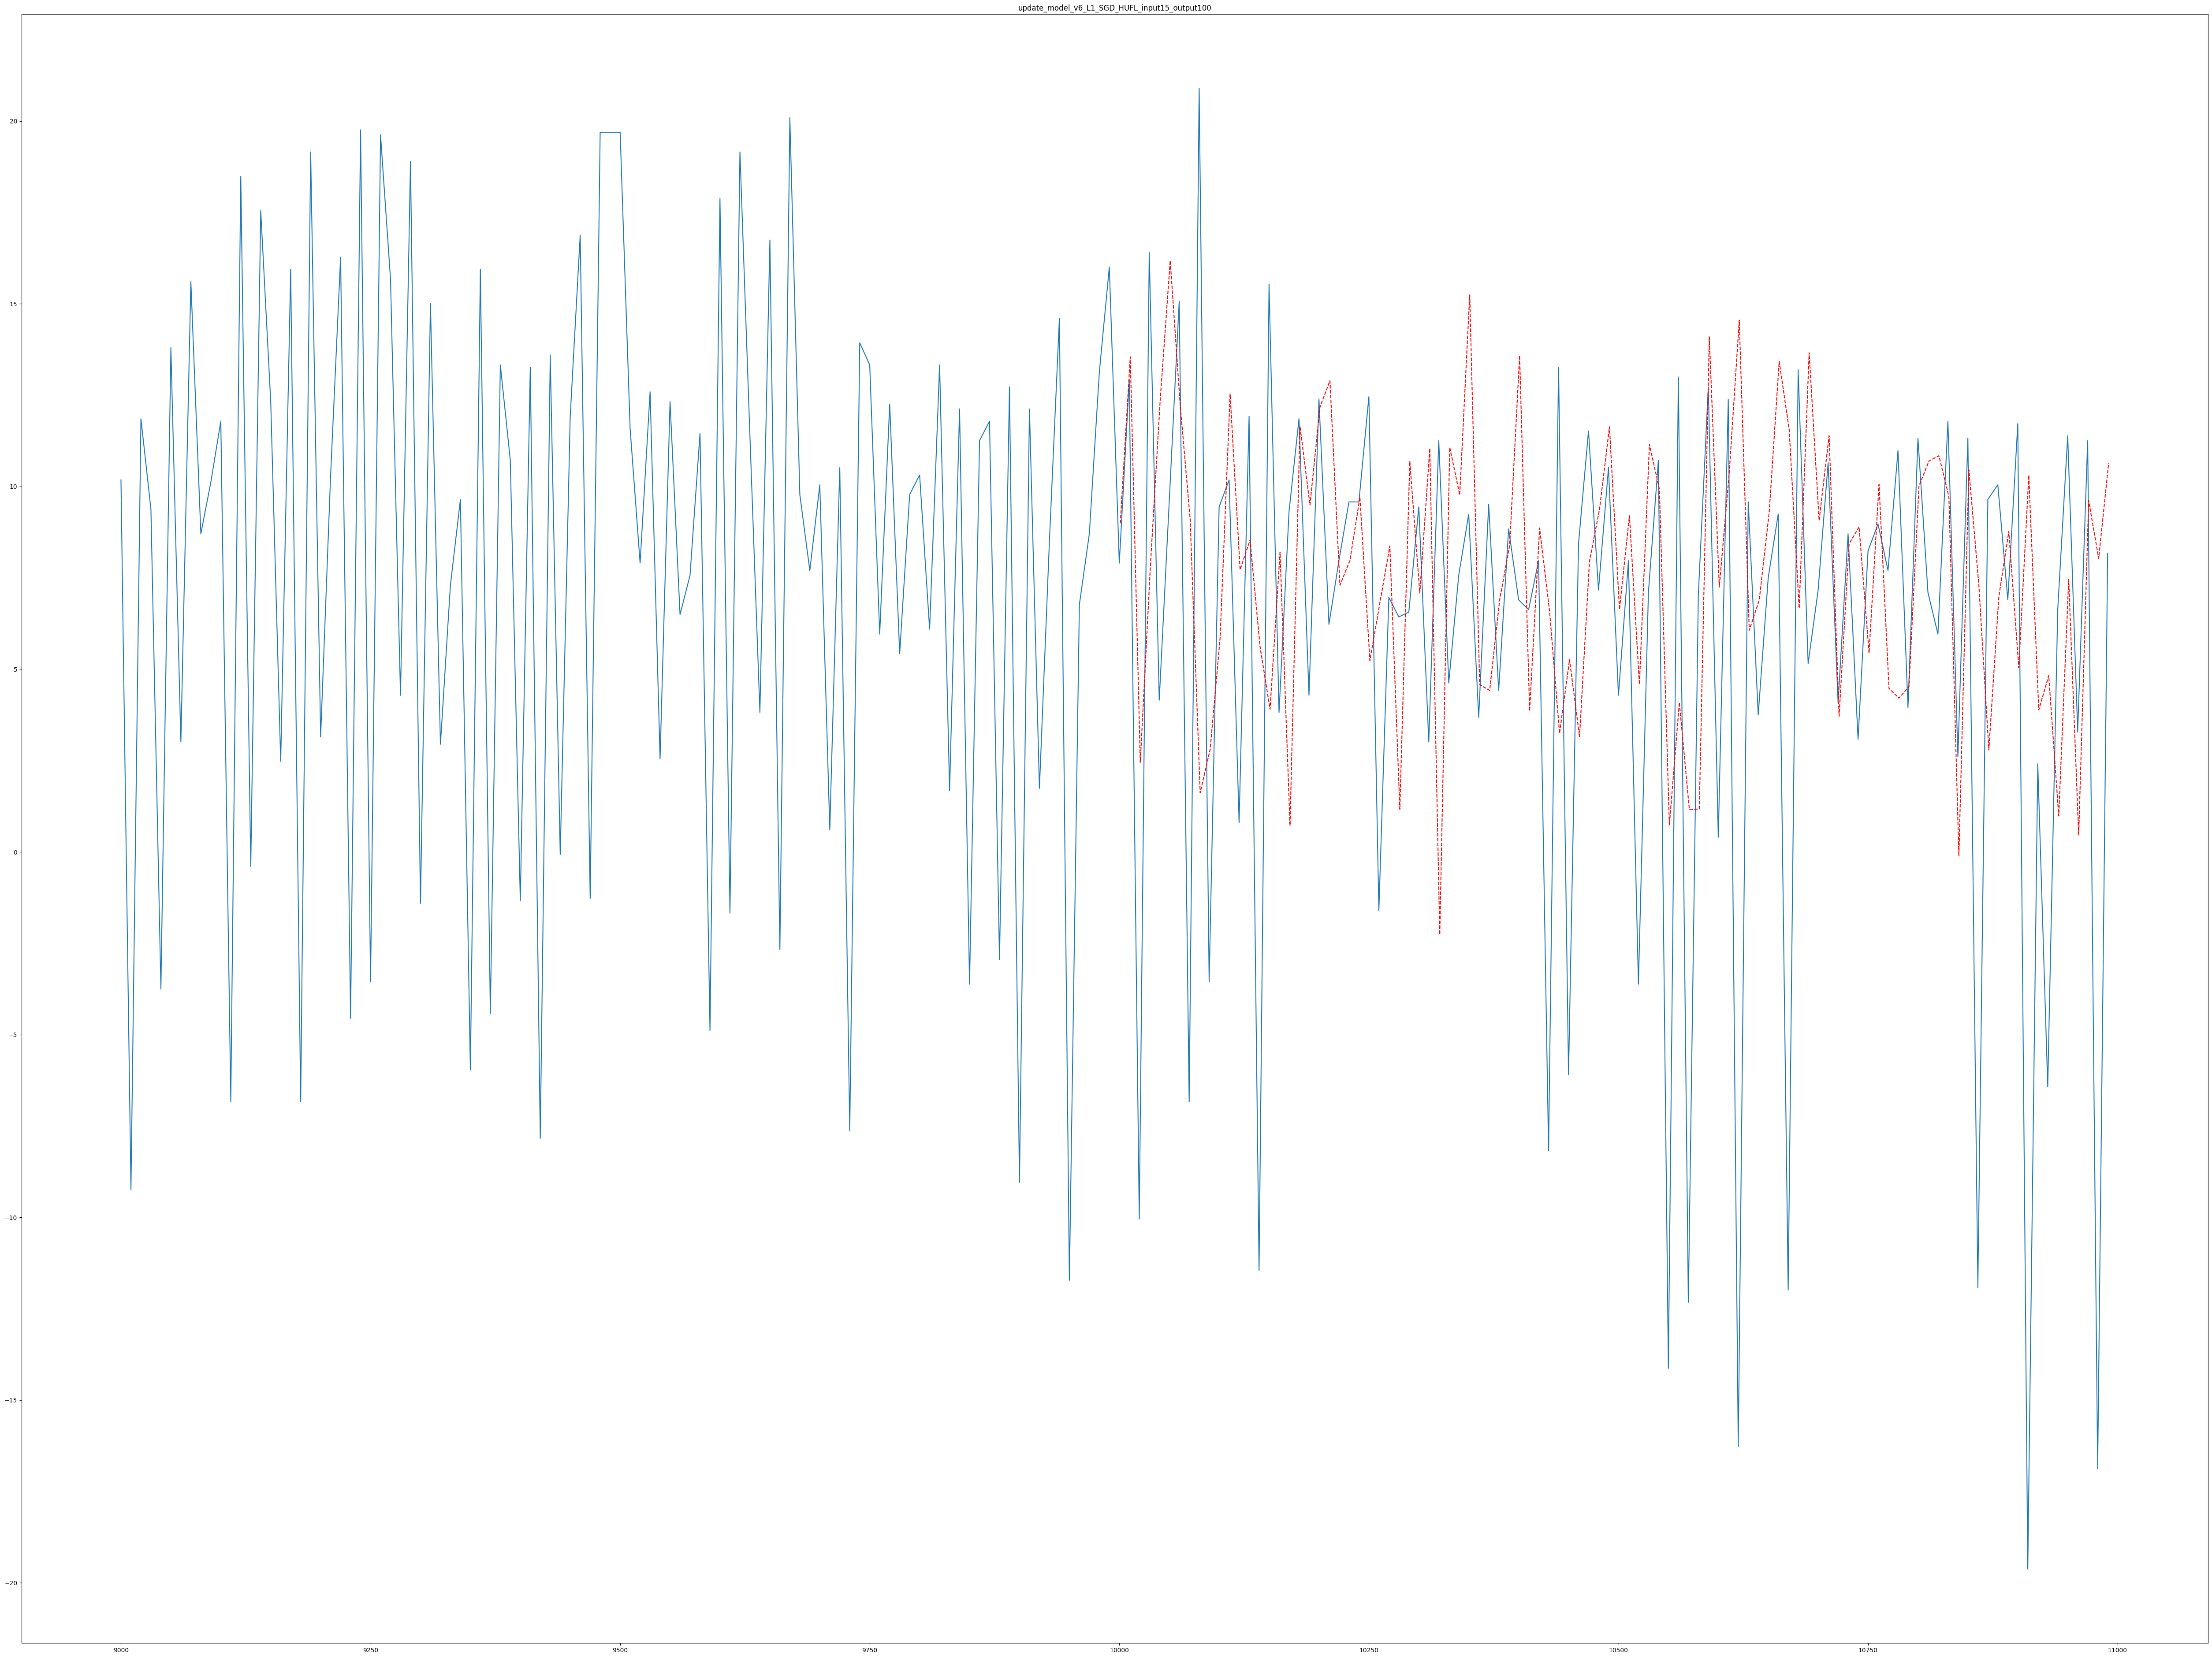

In [104]:

print("Future Predictions:", future_predictions)
time = [data_set-output_size*step+i*step for i in range(2*output_size)]
print(output_size)
plt.rcParams["figure.figsize"] = (64,48)
plt.plot(time, data[column_name].values[data_set-output_size*step:data_set+(output_size)*step:step])
#plt.plot(, )
pred = data[column_name].values[data_set-1]
time = [data_set+1+i*step for i in range(output_size)]

    
plt.plot(time, future_predictions[::], 'r--')
plt.title(model_name)
plt.show()
#plt.savefig(model_name+"2", dpi=1000)


